In [3]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
import torch

from tqdm import tqdm
import pickle
from torch import nn
from torch.optim import Adam,RMSprop
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import math
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
import random
from torchvision import models
from torch.nn import TripletMarginLoss
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
import sklearn
import cv2

## Detecting Language of Image

In [ ]:
from tesserocr import PyTessBaseAPI

def langdetect(path):
    images = ['b.jpg']
    images[0] = path
    count = 0
    count2 = 0
    #replace Tesseract path by the path on your pc
    
    with PyTessBaseAPI(path =r"C:\Program Files\Tesseract-OCR\tessdata" ,lang = "hin") as api:
        for img in images:
            api.Init()
            api.SetImageFile(img)
            # print api.AllWordConfidences()
            arr = list(api.AllWordConfidences())
            sumarr = sum(arr) / float(max(len(arr),0.0001))


    with PyTessBaseAPI(path =r"C:\Program Files\Tesseract-OCR\tessdata" ,lang = "eng") as api:
        for img in images:
            api.Init()
            api.SetImageFile(img)
            # print api.AllWordConfidences()
            arr2 = list(api.AllWordConfidences())
            sumarr2 = sum(arr2) / float(max(len(arr2),0.0001))






    n = min(len(arr) , len(arr2))
    for i in range(0 , n):
        if (arr[i] > arr2[i]):
            count += 1
        elif (arr2[i] > arr[i]):
            count2 += 1
        
        else:
            pass



    if (count2 > count):
            lang = "English"
            conf = sumarr2
            api.Init(lang = 'eng')
            api.SetImageFile(images[0])
            return(lang,conf)
    else:
            lang = "Hindi"
            conf = sumarr
            api.Init(lang = 'hin')
            api.SetImageFile(images[0])
            return (lang,conf)


In [ ]:
images_list = [] #will be used for the negative in triplet loss
for i,author_name in tqdm(enumerate(authors)):
    images = os.listdir(os.path.join(path,author_name))
    random.shuffle(images)
    label = i
    for j in images:
        path_to_append = os.path.join(path,author_name,j)
        if langdetect(path_to_append)[0]!="Hindi" or langdetect(path_to_append)[1]<=1e-2:
            for _ in range(10):
                images_list.append([path_to_append,label])
        else:
            images_list.append([path_to_append,label])
            
#Over Sampling the non hindi images by 10 

In [2]:
# import pickle 
# with open ("images_list.pickle","rb") as file:
#     images_list = pickle.load(file)

In [4]:
len(images_list)

47112

In [5]:
class mDataset(Dataset):
  def __init__(self,array,transform ):
    self.array =array
    self.transform = transform
    
  def __getitem__(self,index):
    
    
        indexlist = self.array[index]
        img0 = Image.open(indexlist[0])
        
        #img0 = img0.convert("L")
        img0 = self.transform(img0)
        label = indexlist[-1]
        
        if(len(indexlist)==3):
          img1 = Image.open(indexlist[1])
          #img1 = img1.convert("L")

          img1 = self.transform(img1)
          return img0,img1,label
        else:
          return img0,label
    

    
    
  def __len__(self):
    return len(self.array)

In [6]:
mytraintransform = transforms.Compose([transforms.Resize((256,256)),transforms.CenterCrop(224) ,transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])]
                               )
myvaltransform = transforms.Compose([transforms.Resize((256,256)),transforms.CenterCrop(224) ,transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])]
                               )

to_tensor = transforms.Compose([transforms.ToTensor(),
                               ])

In [32]:

train_ds = mDataset(images_list,transform=mytraintransform)
train_dataloader = DataLoader(train_ds)

In [9]:
df = pd.read_csv(r'dataset/val.csv')

df

,img1_name,img2_name,label
0,70a4ba9a.jpg,58f68a00.jpg,1
1,e15b612e.jpg,16ce5df2.jpg,0
2,6c64d988.jpg,735d3636.jpg,1
3,b74681a6.jpg,cb50496d.jpg,0
4,c97aa428.jpg,6f9dc747.jpg,1
...,...,...,...
5765,4e7762f7.jpg,2f3d2bce.jpg,0
5766,c1c49f87.jpg,1072597f.jpg,0
5767,03e66099.jpg,f877b1b6.jpg,1
5768,8e056e51.jpg,f68e79a1.jpg,1


In [33]:
class SiamesepairwiseDataset(Dataset):
  def __init__(self,array,path= None,transform = None):
    self.array =array
    self.transform = transform
    self.path = path
    
  def __getitem__(self,index):
    
    indexlist = self.array[index]
        
    if self.path is None:
      img0 = Image.open(indexlist[0])
      img0 = img0.convert("RGB")

      img1 = Image.open(indexlist[1])
      img1 = img1.convert("RGB")


      
    else:
      img0 = Image.open(os.path.join(self.path,indexlist[0]))
      img0 = img0.convert("RGB")

      img1 = Image.open(os.path.join(self.path,indexlist[1]))
      img1 = img1.convert("RGB")

    
    label = indexlist[2]
    
    if self.transform is not None:
        
      img0 = self.transform(img0)
      img1 = self.transform(img1)
    


      
      
    return img0,img1,label
    
  def __len__(self):
    return len(self.array)

In [34]:
val_dataset = SiamesepairwiseDataset(np.array(df),path = r'dataset/val',transform=myvaltransform)
val_dataloader = DataLoader(val_dataset)

In [35]:
pretrainednet = models.mobilenet_v2(weights="DEFAULT")

pretrainednet

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [36]:
class Network(nn.Module):
    def __init__(self,pretrain = pretrainednet):
        super(Network,self).__init__()
        self.pretrained = pretrain
        self.tail = nn.Linear(1000,1352)
    def forward(self,*args):
        ans = []
        for arg in args:
            ans.append(self.tail(self.pretrained(arg)))
        return ans

In [37]:
model = Network()
optimiser = Adam(model.parameters())
criterion = nn.CrossEntropyLoss()


In [38]:

def train():
    model.train()
    Tloss = 0
    for i in tqdm(train_dataloader):

        optimiser.zero_grad()
        img,label = i
        output = model(img)[0]
       
        loss = criterion(output,label)
        Tloss+= loss.item()
        loss.backward()
        optimiser.step()
    print(Tloss/len(images_list))
def test():
    model.eval() 

    with torch.no_grad():
           
            testX = np.zeros(5770)
            y_true = np.zeros(5770)
        
            sumdist = 0
            counter = 0
            batch_size = 1

            for i in tqdm(val_dataloader):
                
                img0,img1,label = i
                
                #img0,img1 = img0.cuda(),img1.cuda()
                
                output1 = model.pretrained(img0)
                output2 = model.pretrained(img1)
                
                diff = output1 - output2
                
                
                dist_sq = torch.sum(torch.pow(diff, 2), 1)
                dist = torch.sqrt(dist_sq)
                
                if(counter+batch_size-1<5770):
                    testX[counter:counter+batch_size] = dist.cpu()
                    y_true[counter:counter+batch_size]  = label
                    counter+=batch_size
                else:
                    testX[counter:] = dist.cpu()
                    y_true[counter:] = label
            sns.kdeplot(testX[y_true==1],color = "blue",label = "1")
            sns.kdeplot(testX[y_true==0],color = "red",label = "0")
            plt.legend()
            plt.show()
            return testX,y_true

100%|██████████| 47112/47112 [2:31:50<00:00,  5.17it/s]  


5.658801728614494


100%|██████████| 5770/5770 [09:42<00:00,  9.90it/s]


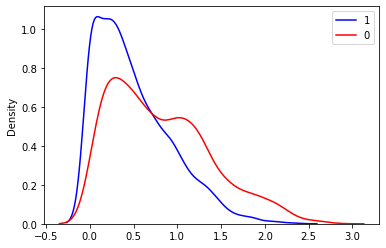

In [39]:
n_epochs = 1

for i in range(n_epochs):
    
    train()
    testX,y_true= test()



In [41]:
torch.save(model.state_dict(),"modelmobile.pth")

In [23]:
testX

array([0., 0., 0., ..., 0., 0., 0.])

In [42]:
y_pred = [1 if i <=0.8 else 0 for i in testX]
roc_auc_score(y_true,y_pred)

0.6145580589254767